## Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

## Data

### Actual and TimeGPT forecats

In [17]:
df_train = pd.read_parquet('M3_month_processed.parquet')
df_eval = pd.read_parquet('M3_month_simple_forecasts.parquet')

### Other methods used in competition

In [18]:
def read_all_sheets(excel_path):
    """
    Reads all sheets from an Excel file and combines them into a single DataFrame.
    
    Args:
    - excel_path (str): The path to the Excel file.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the combined data from all sheets.
    """
    # Use pandas to read the Excel file and get sheet names
    xls = pd.ExcelFile(excel_path)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        
        # Optionally, add a column to indicate the source sheet, if needed
        df['Sheet'] = sheet_name
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

excel_path = '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/M3Forecast.xls'
combined_df = read_all_sheets(excel_path)
# Rename columns
combined_df.rename(columns = {0 : 'Series', 1 : 'NF'}, inplace = True)

# Change series to int in the same fashion as the other dataframes
combined_df['Series'] = combined_df['Series'].str.replace('N', '')
combined_df['Series'] = combined_df['Series'].str.replace(' ', '')
combined_df['Series'] = combined_df['Series'].astype(int)
# Only yearly data for this evaluation
combined_df = combined_df.loc[(combined_df['Series'] >= 1402) & (combined_df['Series'] <= 2829)].copy()
# Drop not necessary columns
cols_to_drop = list(range(8, 19+1))
combined_df.drop(columns = cols_to_drop, inplace = True)

In [19]:
# Change position of sheet column
cols = combined_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
combined_df = combined_df[cols]

# Rename columns so that 1 is the first forecast period
combined_df.rename(columns=lambda x: x - 1 if isinstance(x, int) else x, inplace=True)

# Melt the dataframe i.e. unpivot
df_long = pd.melt(combined_df, id_vars=['Sheet', 'NF' , 'Series'], value_name='value', var_name='ForecastPeriod')   

# Sort the dataframe
df_long = df_long.sort_values(by=['Sheet', 'Series', 'ForecastPeriod']).copy()

## Official Evaluation Metrics
Five accuracy measures:
1. Symmetric MAPE

2. Average Ranking

3. Median symmetric APE

4. Median RAE

5. RMSE (root mean squared error)

Forecasting metrics calculations with assist of github repository:
https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

In [20]:
%run '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/forecasting_metrics.py'

#### NB! When using methods from this file nothing is multiplied with 100 for percentage operations!

## Evaluation

### First group all data together in one dataframe
Make sure it is correctly sorted! 

In [21]:
grouped_df = pd.merge(df_train, df_eval, on = ['Series', 'Date'], how = 'left')
grouped_df.dropna(subset = 'TimeGPT', inplace = True)

In [22]:
# Add forecast period column to replace dates and prepare for merging
grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()

<ipython-input-22-f8af0542ec1b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()


In [23]:
### IMPORTANT ###
# Resort the dataframe to ensure correct evaluation
grouped_df = grouped_df.sort_values(by = ['Series', 'Date', 'Category']).copy()
grouped_df['ForecastPeriod'] = grouped_df.groupby('Series').cumcount() + 1

In [24]:
final_df = pd.merge(grouped_df, df_long, on = ['Series', 'ForecastPeriod'], how = 'left')
# Drop not necessary columns
final_df.drop(columns = ['NF_x', 'N', 'NF_y', 'Date'], inplace = True)
final_df.rename(columns = {'Value' : 'Actual', 'value' : 'Forecast', 'Sheet' : 'Method'}, inplace = True)
final_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)

In [25]:
timegpt_df = final_df.copy()
timegpt_df['Forecast'] = timegpt_df['TimeGPT']

# Step 2: Update the Method column
timegpt_df['Method'] = 'TimeGPT'

# Optional: If you want to remove original TimeGPT rows from the original df
# You might skip this step if you want to keep both Forecast and TimeGPT as separate methods
df = final_df.drop(columns=['TimeGPT'])

# Step 3: Concatenate the modified TimeGPT dataframe with the original dataframe
updated_df = pd.concat([df, timegpt_df])

In [26]:
updated_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)
updated_df.drop(columns = 'TimeGPT', inplace = True)
updated_df.drop_duplicates(inplace= True)

### Aggegated

In [27]:
def smape(a, f):
    """
    Calculate the symmetric mean absolute percentage error (sMAPE).
    Args:
    - a (np.array): An array of actual values.
    - f (np.array): An array of forecast values.
    """
    a = np.array(a)
    f = np.array(f)
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

results = []

# Adjusting to group by 'Series', 'Category', 'Method', and 'ForecastPeriod'
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    smape_value = smape(group['Actual'], group['Forecast'])
    
    results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'sMAPE': smape_value
    })

results_df = pd.DataFrame(results)


In [28]:
results_df.reset_index(inplace = True, drop = True)

In [29]:
results_df

,Series,Category,Method,ForecastPeriod,sMAPE
0,1402,MICRO,AAM1,1,66.983373
1,1402,MICRO,AAM1,2,9.813875
2,1402,MICRO,AAM1,3,43.817787
3,1402,MICRO,AAM1,4,150.155763
4,1402,MICRO,AAM1,5,49.223947
...,...,...,...,...,...
214195,2829,OTHER,WINTER,2,13.170565
214196,2829,OTHER,WINTER,3,13.290109
214197,2829,OTHER,WINTER,4,11.558698
214198,2829,OTHER,WINTER,5,10.465769


In [30]:
print(results_df.loc[(results_df['Method'] == 'ARARMA') &
                     (results_df['ForecastPeriod'] == 6)]['sMAPE'].mean())
### Works! ###

19.847629740593618


#### Function that returns all eval metrics specified in competition

In [32]:
def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))

def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray):
    """Relative Error"""
    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)

def _error(actual: np.ndarray, forecast: np.ndarray):
    return actual - forecast
# Adjusting to group by 'Series', 'Category', 'Method', and 'ForecastPeriod'
full_results = []
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    smape_value = smape(group['Actual'], group['Forecast'])
    smdape_val = smdape(group['Actual'], group['Forecast'])
    rmse_val = rmse(group['Actual'], group['Forecast'])

    benchmark_group = benchmark[(benchmark['Series'] == series) & (benchmark['ForecastPeriod'] == period)]
    if not benchmark_group.empty:
        benchmark_forecast = benchmark_group['Forecast'].values
    else:
        # Handle missing benchmarks if necessary
        benchmark_forecast = np.array([np.nan] * len(group))
    
    # Calculate MDRAE using the benchmark forecast
    mdrae_val = mdrae(group['Actual'].values, group['Forecast'].values, benchmark_forecast)

    full_results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'sMAPE': smape_value,
        'sMDAPE': smdape_val,
        'MDRAE': mdrae_val,
        'RMSE': rmse_val
    })

full_results_df = pd.DataFrame(full_results)

full_results_df.reset_index(inplace = True, drop = True)


In [33]:
print(full_results_df.loc[(full_results_df['Method'] == 'ARARMA') &
                     (full_results_df['ForecastPeriod'] == 6)]['sMAPE'].mean())
### Works! ###

19.847629740593618


### Plots of different evaluation metrics

#### RMSE

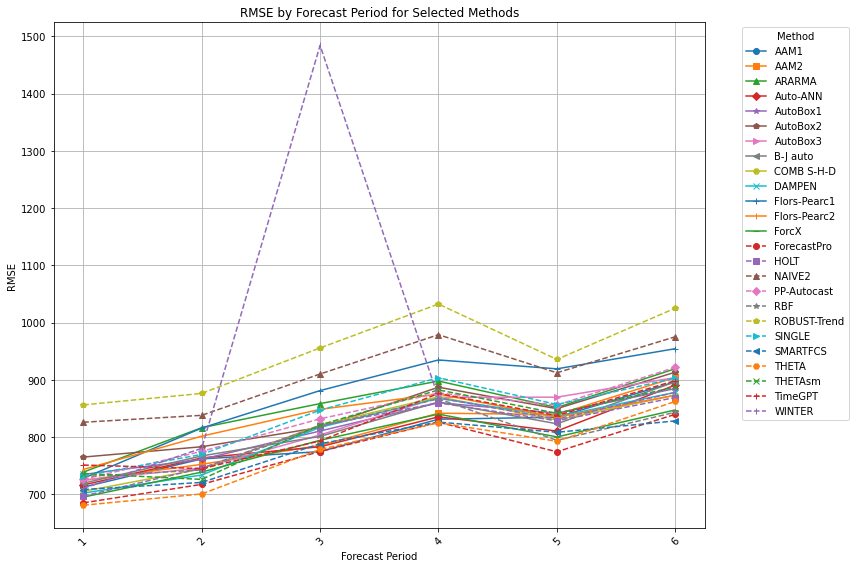

In [35]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['RMSE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='RMSE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('RMSE')
plt.title('RMSE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Symmetric Median APE (Absolute percentage error)

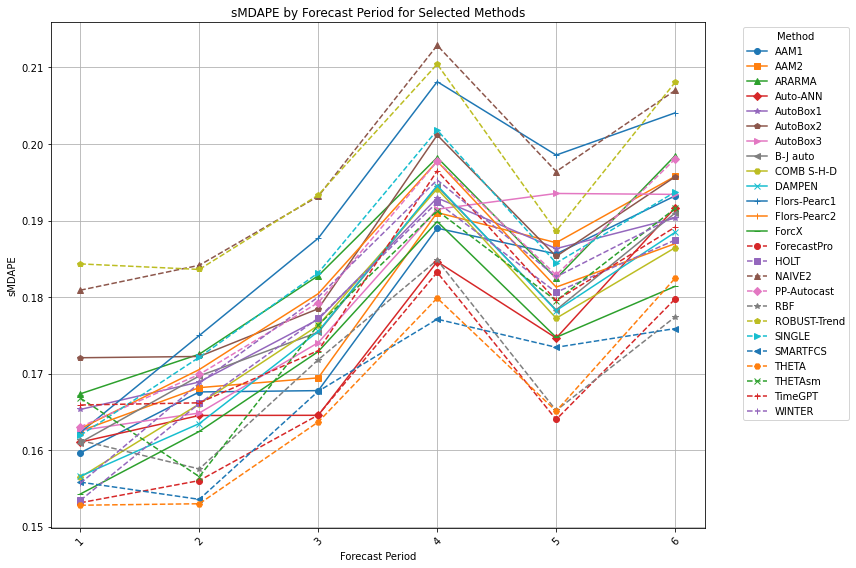

In [36]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['sMDAPE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='sMDAPE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('sMDAPE')
plt.title('sMDAPE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### sMAPE (Symmetric Mean Absolute Percentage Error)

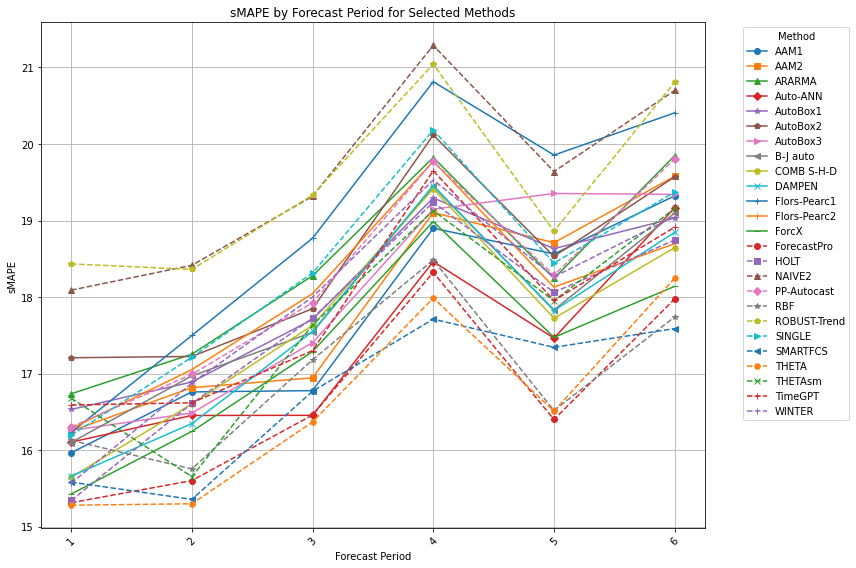

In [37]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['sMAPE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='sMAPE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('sMAPE')
plt.title('sMAPE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### mdRAE (Median Relative Absolute Error)

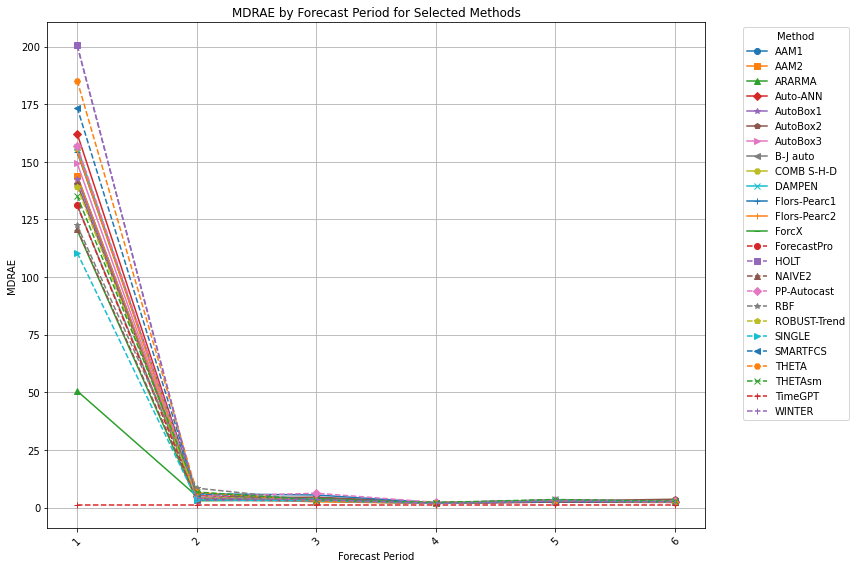

In [38]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['MDRAE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='MDRAE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('MDRAE')
plt.title('MDRAE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Combined plot

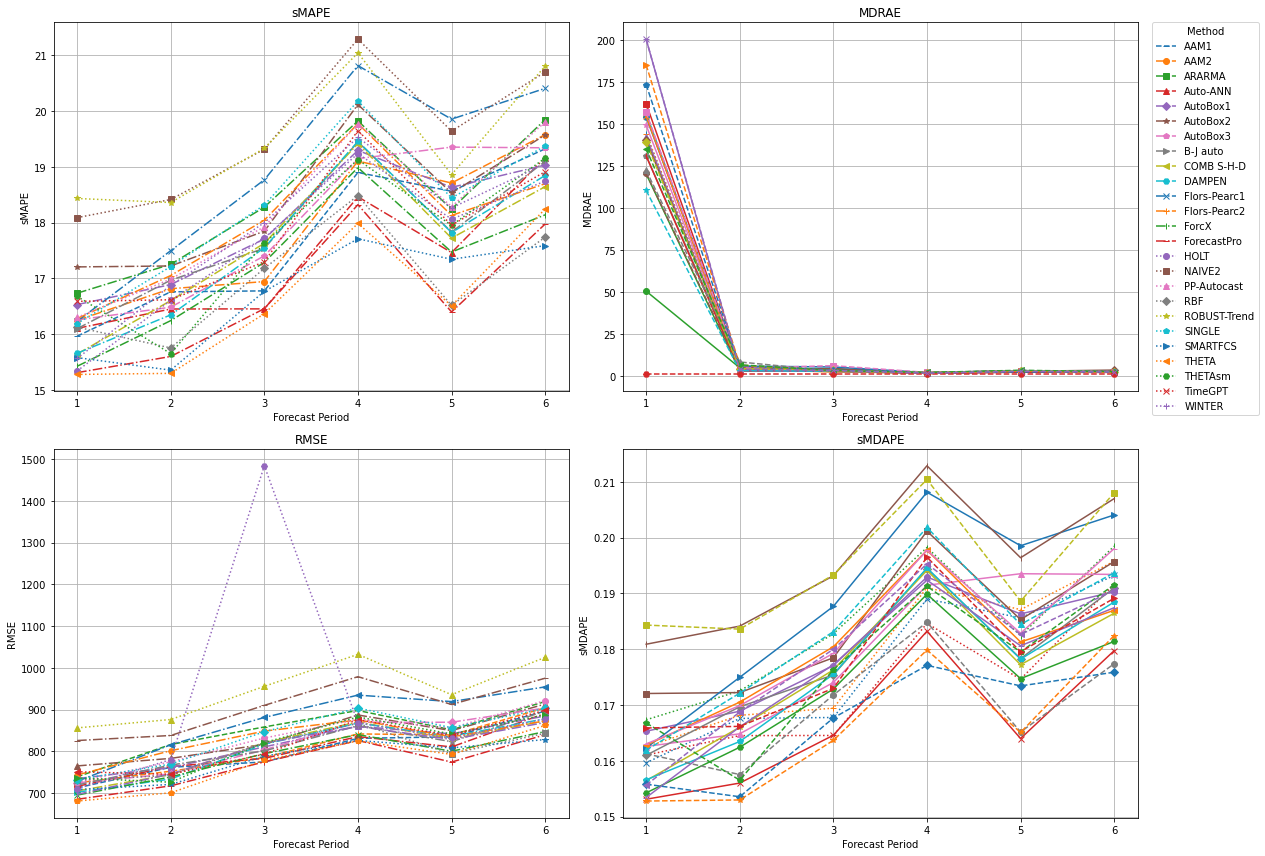

In [39]:
# Define the metrics to plot
metrics = ['sMAPE', 'MDRAE', 'RMSE', 'sMDAPE']

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten the array for easy indexing

# Collect legend handles and labels
handles, labels = [], []

for i, metric in enumerate(metrics):
    # Group and aggregate the data for the current metric
    agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])[metric].mean().reset_index()
    pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values=metric)

    for method, style in zip(pivot_df.columns, cycle(style_cycler)):
        line_style, marker = style
        line, = axs[i].plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)
        if i == 0:  # Only add to legend for the first metric
            handles.append(line)
            labels.append(method)

    axs[i].set_title(metric)
    axs[i].set_xlabel('Forecast Period')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Add a single legend outside the right side of the subplots
fig.legend(handles, labels, title='Method', loc='upper right', bbox_to_anchor=(1.1, 0.975))

plt.tight_layout()
plt.show()
